In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import sklearn.datasets

def prepare_swissroll_data(BATCH_SIZE=1000):
    data = sklearn.datasets.make_swiss_roll(
                    n_samples=BATCH_SIZE,
                    noise=0.25
                )[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 2#7.5 # stdev plus a little
    return data

def plot_2d_data(X, title=None, ax=None, ax2=None, vae=None):
    if ax is None:
        if vae is not None:
            fig = plt.figure(figsize=(5,10))
            ax = fig.add_subplot(2,1,1)
            ax2 = fig.add_subplot(2,1,2)
        else:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(1,1,1)
    
    if title is not None:
        ax.set_title(title, fontsize=20)
        
    #ax.set_xlim(-1.6, 2.0); ax.set_ylim(-1.7, 2.1)
    ax.scatter(X[:,0], X[:,1], alpha=0.5)
    if vae is not None:
        sample_size=1000
        Z = tf.random.normal(shape=(sample_size, vae.enc.dim_Z))
        x_fake = vae.dec(Z)
        #ax.set_title("X", fontsize=20)
        ax.scatter(x_fake[:,0], x_fake[:,1], marker='.', alpha=0.5, color='red', label='dec(z)')
        lgd = ax.legend(fontsize=20, loc='upper left')
        for text in lgd.get_texts():
            text.set_color("red")
        ax2.set_xlim(-3, 3); ax2.set_ylim(-3, 3)
        ax2.set_title("Z", fontsize=20)
        ax2.scatter(Z[:,0], Z[:,1], marker='.', alpha=0.5, color='red')
        mu_enc, l_enc = vae.enc(X)
        ax2.scatter(mu_enc[:,0], mu_enc[:,1], alpha=0.5,color='C0', label='enc(x)(mu)')   
        lgd = ax2.legend(fontsize=20, loc='upper left')
        for text in lgd.get_texts():
            text.set_color("C0")

def show(X, titles=None, horizontal=False):
    batch_size = X.shape[0]
    size = ceil(batch_size**(1/2))
    if horizontal:
        fig = plt.figure(figsize=(batch_size, size))
    else:
        fig = plt.figure(figsize=(size, size))
    for img_label in range(batch_size):
        if horizontal:
            ax = fig.add_subplot(1, batch_size, img_label+1)
        else:
            ax = fig.add_subplot(size, size, img_label+1)
        ax.axis("off")
        try:
            ax.imshow(X[img_label])
        except TypeError:
            ax.imshow(X[img_label,:,:,0], cmap='gray')
        if titles is not None:
            ax.set_title(titles[img_label])
    plt.show()

## 8-1. 変分自己符号化器

### 潜在変数 と ニューラルネット
ニューラルネットワークで生成モデル $p_\theta(x)$ を作るにはどうすればよいでしょうか。ニューラルネットワークはここまで紹介してきたとおり「入力」と「出力」があるような関数なのでした。そうすると $x$ しか引数にないようなものを表現できないような気がします。

一つの方法は、何らかの「$x$の特徴を反映した空間」があるとして、その座標を$z$とします。そして $z$ 上に手で確率密度 $p(z)$ を設定し、

$$
p_\theta(x|z)
$$

をモデル化することにする方法があります。$z$ を**潜在変数(latent variable)** といいます。こうしておけば $p_\theta(x, z) = p_\theta(x|z) p(z)$ の $z$ について周辺化を取ると

$$
p_\theta(x) = \int dz \ p_\theta(x|z) p(z)
$$

は $x$ についてのみの確率分布になります。

### 対数尤度とELBO
ところで、負の対数尤度を用いた最尤推定は

$$ 
- \log p_\theta(x)
=-
\log \Big(
\int dz \ p_\theta(x|z) p(z)
\Big) \tag{1}
$$

が計算できねばならず、これはニューラルネットワークで$p_\theta(x|z)$を実装していると積分値についての閉じた形式を知らないため、困難に思えます。ベイズの定理を思い出すと

$$
{\color{blue} {p_\theta(z|x)}}:=
\frac{p_\theta(x|z) p(z)}{\color{red}{p_\theta(x)}}
$$

によってモデル $p_\theta(x|z)$ を設定した時に、$x$が与えられた時どのような潜在空間の元 $z$ が対応すべきかの **事後確率** を定義できるでしょう。この右辺の分母に ${\color{red}{p_\theta(x)}}$ があるので、$(1)$ の左辺に代入してみましょう。

$$
-\log {\color{red}{p_\theta(x)}} = - \log \frac{p_\theta(x|z) p(z)}{\color{blue}{p_\theta(z|x)}}
$$

一見、特にこれ以上何もできなさそうですが、ここで一工夫します。logの分子は潜在モデル $p_\theta(x|z)$ で書けていますが、分母の事後確率 ${\color{blue}{p_\theta(z|x)}}$ が難しいわけです。そこで事後確率を「まねる」モデル ${\color{green}{q_\varphi(z|x)}}$ を導入してみます。パラメータは後で決めます。これを $1 = \frac{{\color{green}{q_\varphi(z|x)}}}{{\color{green}{q_\varphi(z|x)}}}$ として log の内部に掛け算します：

$$
\left. \begin{array}{ll} -\log {\color{red}{p_\theta(x)}} 
&=- \log \Big( \frac{p_\theta(x|z) p(z)}{\color{blue}{p_\theta(z|x)}}
\times
\frac{{\color{green}{q_\varphi(z|x)}}}{{\color{green}{q_\varphi(z|x)}}}
\Big)
\\
&= - \Big(
\log \frac{{\color{green}{q_\varphi(z|x)}}}{\color{blue}{p_\theta(z|x)}}+
\underbrace{
\log \frac{p_\theta(x|z) p(z)}{{\color{green}{q_\varphi(z|x)}}}
}_{-
\log \frac{{\color{green}{q_\varphi(z|x)}}}{p(z)}+
\log p_\theta(x|z) 
}
\Big)
\\
&= - \log \frac{{\color{green}{q_\varphi(z|x)}}}{\color{blue}{p_\theta(z|x)}}+ \log \frac{{\color{green}{q_\varphi(z|x)}}}{p(z)} -
\log p_\theta(x|z) 
\end{array} \right.
\tag{2}
$$

この量は $z$ に依存するように見えますが、もとの定義 $(1)$ に戻ると、$x$ に依存するのみで $z$ には依存しないことがわかります。$z$に依存しないので任意の $z$ の確率分布で期待値計算(積分)しても値が不変なはずです。そこで $z$ の確率分布として ${\color{green}{q_\varphi(z|x)}}$　について期待値を取ることにします：

$$
(2)
=- 
\underbrace{
\Big\langle \log \frac{{\color{green}{q_\varphi(z|x)}}}{\color{blue}{p_\theta(z|x)}}\Big\rangle_{{\color{green}{q_\varphi(z|x)}}}}_{
D_{KL}\big(
{\color{green}{q_\varphi(z|x)}}
\big\| 
{\color{blue}{p_\theta(z|x)}}
\big)
}
+ 
\underbrace{\Big\langle\log \frac{{\color{green}{q_\varphi(z|x)}}}{p(z)}\Big\rangle_{\color{green}{q_\varphi(z|x)}}}_{
D_{KL}\big(
{\color{green}{q_\varphi(z|x)}}
\big\|
p(z)
\big)
}-
\langle \log p_\theta(x|z) \rangle_{\color{green}{q_\varphi(z|x)}}
$$

となるので、スタート地点の負の対数尤度に戻ると

$$
\left. \begin{array}{ll} - \log {\color{red} {p_\theta (x)}}
&=
\underbrace{- 
D_{KL}\Big(
{\color{green}{q_\varphi(z|x)}}
\Big| \Big|
{\color{blue}{p_\theta(z|x)}}
\Big)}_{\leq 0}
+
D_{KL}\Big(
{\color{green}{q_\varphi(z|x)}}
\Big| \Big|
p(z)
\Big) -
\langle \log p_\theta(x|z) \rangle_{\color{green}{q_\varphi(z|x)}}
\\
&\leq %%%%
D_{KL}\Big(
{\color{green}{q_\varphi(z|x)}}
\Big| \Big|
p(z)
\Big)-
\langle \log p_\theta(x|z) \rangle_{\color{green}{q_\varphi(z|x)}} =: L
\end{array} \right.
$$

と書き直せることがわかります。最尤推定ではこの左辺の値をなるべく小さくしたかったわけですが、代わりに最後の $L$ を小さくすると不等式関係から左辺の値も小さくなります。しかも(左辺)=(右辺)となる場合は${\color{green}{q_\varphi(z|x)}}=
{\color{blue}{p_\theta(z|x)}}$に対応します。${\color{green}{q_\varphi(z|x)}}$ は事後確率 ${\color{blue}{p_\theta(z|x)}}$ を真似ることが目的だったので、これも都合が良さそうです。
> このように、事後確率を何らかの別のモデルで近似しにかかるテクニックを「変分推定」といいます。これは多体シュレディンガー方程式の基底状態を求めるときなどに使う、波動関数の変分法と同じ意味合いの用語です。

これらを総合すると、$L$ を小さくすることは最尤推定をしつつ、もしかしたら事後分布推定もできるかもしれないわけです。このような $L$ をevidence lower bound (ELBO)と言います。

> ほんとうは $-L$ がELBOと呼ばれるものです。ELBOと言うときは負の対数尤度最小化ではなく、対数尤度最大化でよく説明されるので、その場合不等式の向きが逆になって $-L$ が下限になります。

そこで元の最尤推定を $L$ の最小化問題に置き換えて解くことが考えられます

$$
\text{min}_{\theta, \varphi} \Big\{
D_{KL} \Big(
q_\varphi (z | x) \Big| \Big|
p(z)
\Big)-
\Big\langle
\log p_\theta(x| z)
\Big\rangle_{q_\varphi (z | x)}
\Big\}
$$



### 変分自己符号化器
この問題設定では、潜在空間上に固定された確率分布 $p(z)$ と

$$
\text{encoder: }
q_\varphi(z|x),\quad \text{decoder: } p_\theta(x|z)
$$

がありますが、[arXiv:1312.6114](https://arxiv.org/abs/1312.6114) にて、ここまでの話を深層ニューラルネットで解く手法が考案されました。それが変分自己符号化器(Variational AutoEncoder, VAE)とよばれるものです。

#### Encoder
上に挙げた確率分布や確率モデルを以下のように設定します：

* $p(z) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{1}{2} z^2 }$
* $q_\varphi(z| x)=
\frac{1}{\sqrt{2 \pi \sigma^2_\varphi(x)}} e^{- \frac{1}{2 \sigma^2_\varphi(x)} (z - \mu_\varphi(x))^2  }$

潜在空間の次元を1次元にしない場合は、ガウス分布としては次元毎に直積を取る形にします。するとKLダイバージェンスの項は1節で計算したガウス分布間のKLダイバージェンスより

$$
D_{KL} \Big(
q_\varphi (z | x) \Big| \Big|
p(z)
\Big) =
\frac{1}{2} \Big(- \log [\sigma_\varphi(x)]^2 - 1 + [\sigma_\varphi(x)]^2 + [\mu_\varphi(x)]^2
\Big)
$$

となります。実装上は $\sigma$ そのものよりも $l =\log \sigma^2$ を使ったほうが良いようです。つまりEncoderを



In [3]:
class Encoder(tf.keras.Model):
    def __init__(self, dim_Z):
        pass
    def call(self, x):
        mu, l = None # 
        return mu, l

のように $q_\varphi (z | x)$ は $x \to [\mu_\varphi(x), \underbrace{\log[\sigma_\varphi(x)]^2}_{=:l_\varphi(x)}]$ をニューラルネットで実装します。この場合KL lossは

$$
\frac{1}{2} \Big(- l_\varphi(x) - 1 + e^{l_\varphi(x)} + [\mu_\varphi(x)]^2
\Big)
$$

なので、そのように実装しておきます：

In [4]:
def KL_loss(mu, l):
    return tf.reduce_mean(-l - 1 + tf.exp(l) + mu**2)/2

#### Decoder
こちらは 潜在ベクトル $z$ を受け取って $p_\theta(x|z)$ が出力できれば良いだけなので、そのままニューラルネットでOKでしょう。問題は $L$ の二項目

$$
-\langle p_\theta(x|z)\rangle_{q_\varphi(z|x)}
$$

をどう計算するかです。これはサンプリングで近似するのが一つの方法ですが、$q_\varphi(z|x)$ から $z$ をサンプルするだけだと、そこで $\varphi$ の依存性が消えてしまい、encoderへと誤差が伝わりません。そこで使われるのが **reparametrization trick** と呼ばれるものです。平均 $\mu$, 分散 $\sigma^2$ のガウス分布からのサンプリングは、$\epsilon$ を平均 $0$ 分散 $1$ のガウス分布からのサンプリングとして

$$
z = \mu + \epsilon * \sigma
$$

で実現できます。これにencoder出力の $\mu_\varphi(x), l_\varphi(x)$ を適用して

$$
z = \mu_\varphi(x) + \epsilon * \exp(l_\varphi(x)/2)
$$

とします。こうしておくと $\varphi$ の依存性が残って、訓練可能になります。このような関数を作っておきます：

In [5]:
def sample_from_N(mu, l):
    ''' reparametrization trick '''
    epsilon = tf.random.normal(shape=l.shape)
    return mu + epsilon*tf.keras.backend.exp(l/2)

この関数の出力 $z$ を入力としたニューラルネットとして decoder は構成します。つまり


In [6]:
class Decoder(tf.keras.Model):
    def __init__(self, dim_Z):
        pass
    def call(self, z):
        x = None
        return x


のようなものを実装すればOKで、lossは

$$
-\log p_\theta(x|z_\text{sampled})
$$

から設定毎に導かれる誤差関数を選べばよいです。この項を**reconstruction loss** といいます。

#### 全体の構造
VAEモデルは2つのネットワークから成ります

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, enc, dec):
        super(VAE, self).__init__()
        self.enc = enc
        self.dec = dec
        
def batch_step(X, vae, opt, reconstruction_loss): # 学習ステップ
    with tf.GradientTape() as tape:
        # encoding step
        mu, l = vae.enc(X)
        # decoding step
        Z = sample_from_N(mu, l)
        X_decoded = vae.dec(Z)
        # loss
        loss = KL_loss(mu, l) + reconstruction_loss(X, X_decoded)
    # update
    grads = tape.gradient(loss, vae.trainable_variables)
    opt.apply_gradients(zip(grads, vae.trainable_variables))
    return loss

### 2次元でVAE
以下のように $X$ を実2次元空間として、その上にスイスロール状に分布したデータを教師なしデータとして、VAEを訓練してみましょう。次節のGANでもスイスロール状データで実験しますが、大きさが微妙に違います（上手くいくパラメータを探した結果こうなりました）。

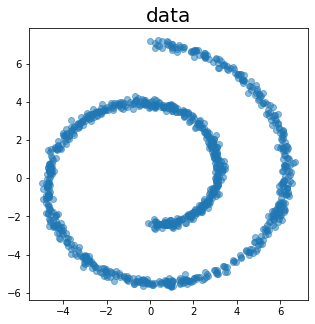

In [80]:
X_2d = prepare_swissroll_data() # 出力はnumpy.array
plot_2d_data(X_2d, title='data'); plt.show()

#### Encoder
3回`Dense`でつないだ単純なものを作ってみました。activationがtanhですが他のやつでも上手くいくかもです。

In [81]:
class Encoder_2d(tf.keras.Model):
    def __init__(self, dim_Z=2, dim_feature=32):
        super(Encoder_2d, self).__init__()
        initializer = tf.initializers.he_normal()
        self.l1 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l2 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l3 = tf.keras.layers.Dense(2*dim_Z, kernel_initializer=initializer)
        self.dim_Z =dim_Z

    def call(self, x):
        h = tf.keras.activations.tanh(self.l1(x))
        h = tf.keras.activations.tanh(self.l2(h))
        h = self.l3(h)
        mu= h[:, :self.dim_Z]
        l = h[:, self.dim_Z:]
        return mu, l        

#### Decoder
こちらも大体似たモデルですactivationはleaky relu（負の部分も少し傾きがあるrelu）です。

In [ ]:
class Decoder_2d(tf.keras.Model):
    def __init__(self, dim_feature=32):
        super(Decoder_2d, self).__init__()
        initializer = tf.initializers.he_normal()
        self.l1 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l2 = tf.keras.layers.Dense(dim_feature, kernel_initializer=initializer)
        self.l3 = tf.keras.layers.Dense(2, kernel_initializer=initializer)

    def call(self, z):
        h = tf.nn.leaky_relu(self.l1(z))
        h = tf.nn.leaky_relu(self.l2(h))
        h = self.l3(h)
        return h
    
    def generate(self, shape):
        Z = tf.random.normal(shape=shape)
        return self(Z)

#### Training
再構成誤差は2次元の距離にしました。訓練中のテストは実際に2次元にプロットすることにします。

In [74]:
def reconstruction_loss_2d(x, x_decoded):
    return tf.reduce_mean(tf.keras.losses.MSE(x, x_decoded))

def train_2d(vae, X_2d, batch_size, epochs):
    tf_batch_step = tf.function(batch_step)
    opt = tf.keras.optimizers.Adam(1e-2)
    D = tf.data.Dataset.from_tensor_slices(X_2d)
    fig = plt.figure(figsize=(5*6,10))
    plotlabel = 1
    for epoch in range(epochs):
        batch = D.shuffle(70000).batch(batch_size, drop_remainder=True)
        for X in batch:
            loss = tf_batch_step(X_2d, vae, opt, reconstruction_loss_2d)
        if epoch%(epochs//5)==0:
            # test
            #print("L =", loss)
            ax = fig.add_subplot(2,6,plotlabel)
            ax2 = fig.add_subplot(2,6,plotlabel+6)
            plot_2d_data(X_2d, title="{}-epoch".format(epoch), vae=vae, ax=ax, ax2=ax2)
            plotlabel += 1
    plt.show()
    return vae

以下の訓練は CPU でもかなり早く完了できます。テストでは
* 上段：データ空間、青色＝データ点、赤色＝デコーダーが潜在空間の赤点からデコードした点
* 下段：潜在空間、青色＝エンコーダーがデータ空間のデータ点をエンコードした点（$\mu$のみ）、赤色＝正規分布$p_z$からのサンプル

として表示しています。

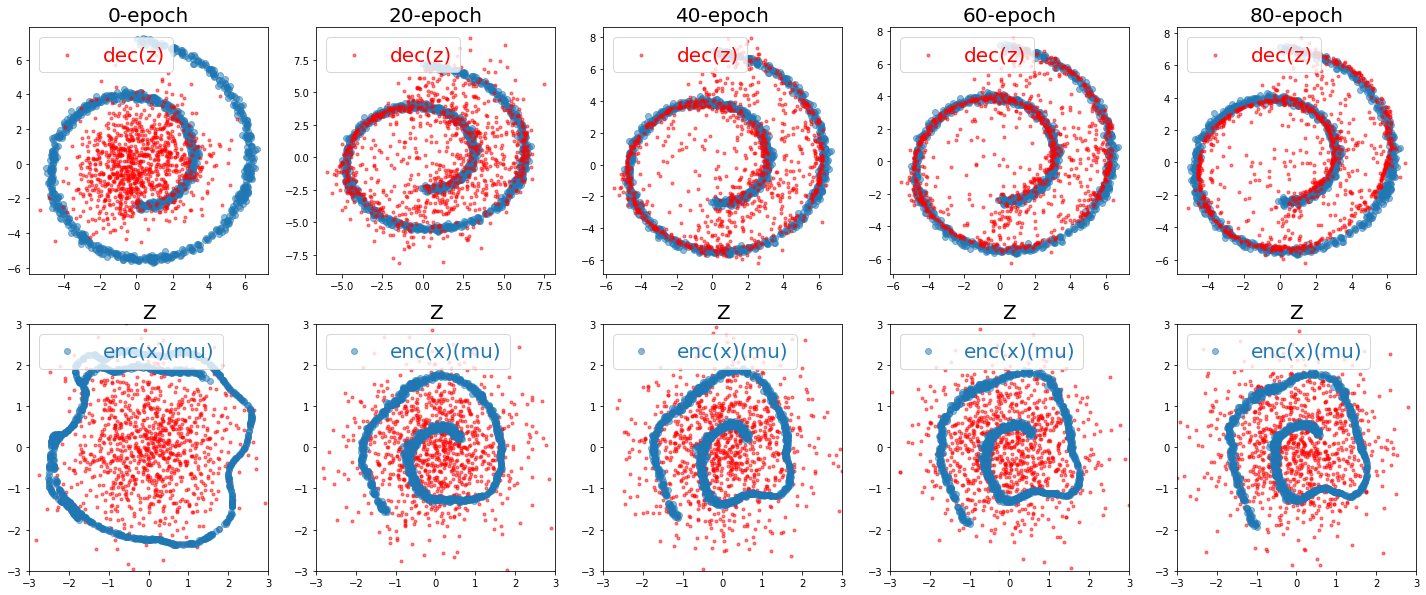

CPU times: user 13.8 s, sys: 1.33 s, total: 15.1 s
Wall time: 8.41 s


In [82]:
%%time
enc_2d = Encoder_2d()
dec_2d = Decoder_2d()
vae_2d = VAE(enc_2d, dec_2d)
train_2d(vae_2d, X_2d, batch_size=32, epochs=100)

このように、うまくいけば
* データ点 $\to p_z$ への埋め込み
* $p_z \to$ データ点への埋め込み

が互いにうまく達成されます。

### MNISTでVAE
次に MNIST でラベル情報を捨てた教師なし学習をVAEでやってみましょう。ネットワークの構成などのパラメータ設定はtensorflowのチュートリアルを参考にしています。まず MNIST をピクセル値 $\in [0,1]$ にして読み込みます。

In [63]:
mnist = tf.keras.datasets.mnist
(X, Y), (X_test, Y_test) = mnist.load_data()
X, X_test = (X/255).astype(np.float32), (X_test/255).astype(np.float32)
X_train = tf.reshape(tf.concat([X, X_test], axis = 0), shape=(70000, 28, 28, 1))

#### Encoder

潜在空間の次元を `dim_Z` とかくことにして、畳込み演算２回と最後に線形変換です：



In [72]:
class Encoder_mnist(tf.keras.Model):
    def __init__(self, dim_Z):
        super(Encoder_mnist, self).__init__()
        self.c1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')
        self.c2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(2*dim_Z)
        self.dim_Z = dim_Z
        
    def call(self, x):
        ''' x.shape = (batchsize, Lx, Ly, C) '''
        h = self.c1(x)
        h = self.c2(h)
        h = self.flatten(h)
        h = self.dense(h)
        mu= h[:, :self.dim_Z]
        l = h[:, self.dim_Z:]
        return mu, l

#### Decoder
転置畳み込み（畳み込みの逆演算）を用いてどんどん画素を大きくするような構造をしています：

In [73]:
class Decoder_mnist(tf.keras.Model):
    def __init__(self):
        super(Decoder_mnist, self).__init__()
        self.dense = tf.keras.layers.Dense(units=7*7*32, activation='relu')
        self.reshape= tf.keras.layers.Reshape(target_shape=(7, 7, 32))
        self.dc1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.dc2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.dc3 = tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same')
        
    def call(self, z):
        h = self.dense(z)
        h = self.reshape(h)
        h = self.dc1(h)
        h = self.dc2(h)
        h = self.dc3(h)
        return tf.keras.activations.sigmoid(h)
    
    def generate(self, shape):
        ''' batch_size, dim_Z = shape '''
        Z = tf.random.normal(shape=shape)
        return self(Z)

最後にsigmoid関数をかけたのは、`X_train` のピクセル値 $\in[0,1]$ としたので、これに合わせるためです。ところでこの場合、各ピクセル毎に確率値が割り振られているので、$-\log p_\theta(x|z_\text{sampled})$ は通常のクロスエントロピーで良いでしょう：

In [80]:
def reconstruction_loss_mnist(x, x_decoded):
    return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_decoded), axis=[1, 2]))

訓練用の関数は以下のようになります：

In [82]:
def train(vae, X_train, batch_size, epochs):
    tf_batch_step = tf.function(batch_step)
    opt = tf.keras.optimizers.Adam(1e-4)
    D = tf.data.Dataset.from_tensor_slices(X_train)
    for epoch in range(epochs):
        batch = D.shuffle(70000).batch(batch_size, drop_remainder=True)
        for X in batch:
            loss = tf_batch_step(X, vae, opt, reconstruction_loss_mnist)
        if epoch%1==0 or epoch==(epochs-1):
            # test
            print("L =", loss)
            dim_Z = vae.enc.dim_Z
            X_generated = vae.dec.generate(shape=(9, dim_Z))
            show(X_generated)
    return vae

実際に訓練してみます。各epoch毎に誤差関数 $L$ の値と $z$ を平均 $0$ 分散 $1$ のガウス分布からサンプルしてdecodeしたものを表示しています。GPUで1分未満で終わると思いますがCPUだと時間がかかります。

L = tf.Tensor(159.06482, shape=(), dtype=float32)


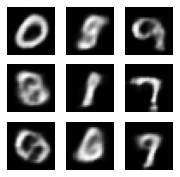

In [83]:
enc = Encoder_mnist(dim_Z=2)
dec = Decoder_mnist()
vae = VAE(enc, dec)
train(vae, X_train, batch_size=32, epochs=5)

#### 画像の「ホモトピー」
訓練後、潜在ベクトル二点の間をinterpolate

$$
x(t) = dec\big( z(t) \big), \quad z(t):z_1 \to z_2
$$

すると、生成画像がなめらかにつながる様子が確認できます：

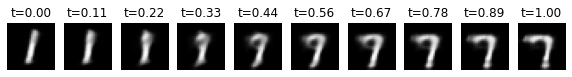

In [102]:
Z1 = tf.random.normal(shape=(1, vae.enc.dim_Z))
Z2 = tf.random.normal(shape=(1, vae.enc.dim_Z))
for t in np.linspace(0,1,10):
    if t==0:
        X_list = vae.dec(Z1)
    else:
        X_generated = vae.dec((1-t)*Z1+t*Z2)
        X_list = tf.concat([X_list, X_generated], axis=0)
show(X_list, titles=["t={:.02f}".format(t) for t in np.linspace(0,1,10)], horizontal=True)

### 関連する話題
VAEを用いて文章生成も可能です。例えば[arXiv:1511.06349](https://arxiv.org/abs/1511.06349) などがあります。この論文ではKL項の前に逆温度を設け、encoderが潰れないように徐々に冷やす正則化がなされています。このようなKL項に温度を設定するVAEは $\beta$-VAE と呼ばれ、盛んに研究されているようです([論文リンク](https://openreview.net/forum?id=Sy2fzU9gl))。

また、ここでは $p(z)$ や $q_\varphi(z|x)$ をガウス分布に取りましたが、最近ではこれらを離散確率分布に取る「ベクトル量子化変分自己符号化器(Vector Quantized Variational Auto-Encoder, VQ-VAE)」というのが良い性能を出すことがわかってきています：[arXiv:1711.00937](https://arxiv.org/abs/1711.00937), [arXiv:1906.00446](https://arxiv.org/abs/1906.00446)。